In [1]:
import json
import re
import random
import itertools
from matplotlib import pyplot as plt

from numpy.random import default_rng

import matplotlib.pyplot as plt
import numpy as np
import copy

%matplotlib inline

from shapely.geometry import *
from shapely.geometry.polygon import Polygon
from shapely import ops

from lloyd import Field
from scipy.spatial import voronoi_plot_2d

rng = default_rng()

num_major_points = 20
num_minor_points = 40
relaxation_amount = 5
exterior_buffer = 0.1
min_building_street_face = 3
mean_building_street_face = 5
max_building_street_face = 20
min_building_depth = 3
mean_building_depth = 7
max_building_depth = 35
min_street_offset = 3
max_street_offset = 3

In [2]:
with open('./redditexample.dungeondraft_map') as f:
    txt = f.read()
m = json.loads(txt)
new_map = copy.deepcopy(m)

In [3]:
type(m)

dict

In [4]:
def gen_node(current):
    current = int(current, 16)
    while True:
        current += 1 
        yield hex(current)[2:]

In [5]:
next_node = gen_node(hex(max([int(s, 16) for s in re.findall('"node_id": "(.*)"', txt)]))[2:])

In [6]:
t = eval(re.findall('\(.*\)', m['world']['levels']['0']['patterns'][0]['points'])[0])
all_lines = list(itertools.pairwise(list(itertools.pairwise(t + t[:2]))[::2]))

In [7]:
p = Polygon([l[0] for l in all_lines])

In [8]:
list(itertools.pairwise(list(itertools.pairwise(list(itertools.chain.from_iterable(p.exterior.coords))))[::2]))

[((2048.0, 3328.0), (2048.0, 2816.0)),
 ((2048.0, 2816.0), (2816.0, 2048.0)),
 ((2816.0, 2048.0), (4608.0, 1024.0)),
 ((4608.0, 1024.0), (6912.0, 1280.0)),
 ((6912.0, 1280.0), (8704.0, 3584.0)),
 ((8704.0, 3584.0), (8704.0, 5888.0)),
 ((8704.0, 5888.0), (4352.0, 6400.0)),
 ((4352.0, 6400.0), (3840.0, 4608.0)),
 ((3840.0, 4608.0), (1792.0, 5632.0)),
 ((1792.0, 5632.0), (512.0, 4608.0)),
 ((512.0, 4608.0), (2304.0, 3840.0)),
 ((2304.0, 3840.0), (2048.0, 3328.0))]

In [9]:
[((0, 0), (1, 1)), ((-1, 0), (1, 0))]

[((0, 0), (1, 1)), ((-1, 0), (1, 0))]

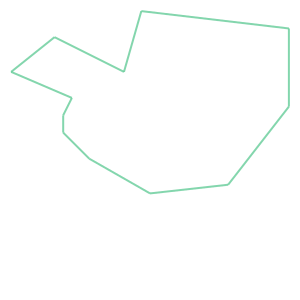

In [10]:
MultiLineString(list(itertools.pairwise(list(itertools.pairwise(list(itertools.chain.from_iterable(p.exterior.coords))))[::2])))

In [11]:
def poly_to_multi_line_string(poly):
    ring = poly.exterior
    if ring.is_ccw:
        ring.coords = ring.coords[::-1]
    return MultiLineString(list(itertools.pairwise(list(itertools.pairwise(list(itertools.chain.from_iterable(ring.coords))))[::2])))
def ring_to_mult_line_string(ring):
    if ring.is_ccw:
        ring.coords = list(ring.coords)[::-1]
    return MultiLineString(list(itertools.pairwise(list(b.interiors[0].coords))))

In [12]:
def cut(line, distance):
    # Cuts a line in two at a distance from its starting point
    if distance <= 0.0 or distance >= line.length:
        return [LineString(line)]
    coords = list(line.coords)
    for i, p in enumerate(coords):
        pd = line.project(Point(p))
        if pd == distance:
            return [
                LineString(coords[:i+1]),
                LineString(coords[i:])]
        if pd > distance:
            cp = line.interpolate(distance)
            return [
                LineString(coords[:i] + [(cp.x, cp.y)]),
                LineString([(cp.x, cp.y)] + coords[i:])]

In [13]:
def get_ridges(vor):
    center = vor.points.mean(axis=0)
    ptp_bound = vor.points.ptp(axis=0)
    finite_segments = []
    infinite_segments = []
    for pointidx, simplex in zip(vor.ridge_points, vor.ridge_vertices):
        simplex = np.asarray(simplex)
        if np.all(simplex >= 0):
            finite_segments.append(vor.vertices[simplex])
        else:
            i = simplex[simplex >= 0][0]  # finite end Voronoi vertex

            t = vor.points[pointidx[1]] - vor.points[pointidx[0]]  # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[pointidx].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            if (vor.furthest_site):
                direction = -direction
            far_point = vor.vertices[i] + direction * ptp_bound.max()

            infinite_segments.append([vor.vertices[i], far_point])

    return finite_segments, infinite_segments

In [14]:
def construct_streets(poly, n_points):
    
    min_x, min_y, max_x, max_y = poly.bounds
    
    x_range = max_x - min_x
    y_range = max_y - min_y
    
    x_buffer = x_range * exterior_buffer
    y_buffer = y_range * exterior_buffer
    
    xs = rng.integers(min_x - x_buffer, max_x + x_buffer, n_points)
    ys = rng.integers(min_y - y_buffer, max_y + y_buffer, n_points)
    points = np.vstack([xs, ys]).T
    field = Field(points)

    for i in range(relaxation_amount):
        field.relax()
    
    mask = []
    for p in field.get_points():
        mask.append(poly.contains(Point(p[0], p[1])))
        
    culled_field = Field(field.get_points()[mask])
    
    finite_segments, infinite_segments = get_ridges(culled_field.voronoi)
    
    streets = MultiLineString(infinite_segments+finite_segments)
    substreets = []
    for line in poly.intersection(streets).geoms:
        substreets.append(list(line.coords))
    split_streets = ops.split(streets, poly)
    split_poly = ops.split(poly_to_multi_line_string(poly), streets)
    return MultiPolygon(ops.polygonize(poly.intersection(streets).union(split_poly))), poly.intersection(streets)

In [15]:
polys, streets = construct_streets(p, num_major_points)

C:\ProgramData\Anaconda3\envs\mapgen\lib\site-packages\shapely\geometry\base.py:250: ShapelyDeprecationWarning: Setting the 'coords' to mutate a Geometry in place is deprecated, and will not be possible any more in Shapely 2.0
  super().__setattr__(name, value)


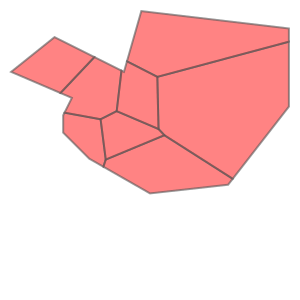

In [16]:
polys

C:\Users\Stephen\AppData\Local\Temp\ipykernel_19020\111933313.py:1: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  subpolys, alleys = construct_streets(polys[4], num_minor_points)


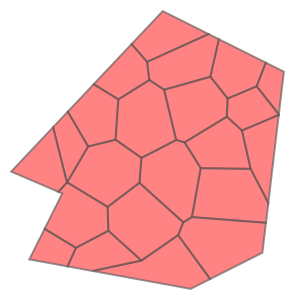

In [17]:
subpolys, alleys = construct_streets(polys[4], num_minor_points)
subpolys

In [18]:
list(subpolys)

C:\Users\Stephen\AppData\Local\Temp\ipykernel_19020\882670920.py:1: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  list(subpolys)
C:\Users\Stephen\AppData\Local\Temp\ipykernel_19020\882670920.py:1: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  list(subpolys)


In [19]:
neighborhood = subpolys[0].exterior.parallel_offset(10, 'right').union(subpolys[0].exterior)

C:\Users\Stephen\AppData\Local\Temp\ipykernel_19020\2219997503.py:1: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  neighborhood = subpolys[0].exterior.parallel_offset(10, 'right').union(subpolys[0].exterior)


In [20]:
f=cut(streets[0], 5)[0]

C:\Users\Stephen\AppData\Local\Temp\ipykernel_19020\4042530884.py:1: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  f=cut(streets[0], 5)[0]


In [21]:
cut(streets[0], 5)

C:\Users\Stephen\AppData\Local\Temp\ipykernel_19020\2955658057.py:1: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  cut(streets[0], 5)


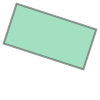

In [22]:
f.union(f.parallel_offset(10, 'right')).minimum_rotated_rectangle

In [23]:
def poly_to_multi_line_string(poly):
    ring = poly.exterior
    if ring.is_ccw:
        ring.coords = ring.coords[::-1]
    return ring_to_mult_line_string(ring)
#     return MultiLineString(list(itertools.pairwise(list(itertools.pairwise(list(itertools.chain.from_iterable(ring.coords))))[::2])))
def ring_to_mult_line_string(ring):
    if ring.is_ccw:
        ring.coords = list(ring.coords)[::-1]
    return MultiLineString(list(itertools.pairwise(list(ring.coords))))

In [24]:
print(poly_to_multi_line_string(p))

MULTILINESTRING ((2048 3328, 2304 3840), (2304 3840, 512 4608), (512 4608, 1792 5632), (1792 5632, 3840 4608), (3840 4608, 4352 6400), (4352 6400, 8704 5888), (8704 5888, 8704 3584), (8704 3584, 6912 1280), (6912 1280, 4608 1024), (4608 1024, 2816 2048), (2816 2048, 2048 2816), (2048 2816, 2048 3328))


In [25]:
from tqdm import tqdm_notebook as tqdm

In [26]:
def scatter_buildings(neighborhood):
    last_remainder = None
    boundry = neighborhood.buffer(10, single_sided=True)
    buildings = []
    for side in neighborhood:
        rem_len = side
        first = True
        while rem_len.length > min_building_depth + min_building_street_face:
            max_remain = min(max_building_street_face, rem_len.length - min_building_depth)
            front_len = random.uniform(min_building_street_face, max_remain-min_street_offset)
            if first and last_remainder is not None:
                depth = last_remainder.length
            else:
                depth = random.uniform(min_building_depth, max_building_depth)

            front, rem_len_temp = cut(rem_len, front_len)
            front_offset = random.uniform(min_street_offset, max_street_offset)
            building = front.parallel_offset(front_offset, 'right').union(front.parallel_offset(depth, 'right')).minimum_rotated_rectangle
            while not MultiPolygon(buildings + [building] + list(boundry)).is_valid:
                if front_len > min_building_street_face:
                    front_len *= .9
                if depth > min_building_depth:
                    depth *= .9
                front, rem_len_temp = cut(rem_len, front_len)

                if front_len < min_building_street_face and depth < min_building_depth:
                    building = None
                    break
                else:
                    building = front.union(front.parallel_offset(depth, 'right')).minimum_rotated_rectangle

            rem_len = rem_len_temp
            last_remainder = rem_len
            if building:
                buildings.append(building)
            first = False
    return MultiPolygon(buildings)
            

In [27]:
min_building_street_face = 64
mean_building_street_face = 10
max_building_street_face = 512
min_building_depth = 256
mean_building_depth = 7
max_building_depth = 512
min_street_offset = 64
max_street_offset = 128

C:\Users\Stephen\AppData\Local\Temp\ipykernel_19020\1063073940.py:3: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  for district in tqdm(list(polys)):
C:\Users\Stephen\AppData\Local\Temp\ipykernel_19020\1063073940.py:3: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for district in tqdm(list(polys)):
C:\Users\Stephen\AppData\Local\Temp\ipykernel_19020\1063073940.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for district in tqdm(list(polys)):


  0%|          | 0/8 [00:00<?, ?it/s]

C:\Users\Stephen\AppData\Local\Temp\ipykernel_19020\189081089.py:5: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for side in neighborhood:
C:\Users\Stephen\AppData\Local\Temp\ipykernel_19020\189081089.py:19: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  while not MultiPolygon(buildings + [building] + list(boundry)).is_valid:
C:\Users\Stephen\AppData\Local\Temp\ipykernel_19020\189081089.py:19: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  while not MultiPolygon(buildings + [building] + list(boundry)).is_valid:
C:\Users

0it [00:00, ?it/s]

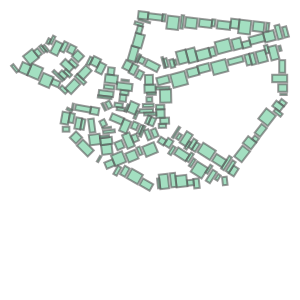

In [28]:
buildings = []
list_neighborhoods = []
for district in tqdm(list(polys)):
    neighborhood = poly_to_multi_line_string(district)
    buildings.extend(scatter_buildings(neighborhood))
#     neighborhoods, alleys = construct_streets(district, num_minor_points)
#     list_neighborhoods.extend(list(neighborhoods))
# for district in tqdm(list(polys)):
#     neighborhoods, alleys = construct_streets(district, num_minor_points)
#     list_neighborhoods.extend(list(neighborhoods))
#     boundry = poly_to_multi_line_string(district).buffer(2, single_sided=True)
#     last_remainder = None
for subpoly in tqdm(list_neighborhoods):
    neighborhood = poly_to_multi_line_string(subpoly)
    buildings.extend(scatter_buildings(neighborhood))
    
MultiPolygon(buildings)

In [29]:
len(buildings)

188

In [30]:
polys.boundary.geom_type

'MultiLineString'

In [31]:
def parameterize_roof(poly):
    edge = MultiLineString(list(itertools.pairwise(list((poly.boundary).coords))))
    short_ind = np.argmin([ls.length for ls in edge])
    short_cent = edge[short_ind].centroid
    full_cent = poly.centroid
    return np.asarray(short_cent), (np.asarray(full_cent)-np.asarray(short_cent))*2+np.asarray(short_cent), edge[short_ind].length/2


In [32]:
parameterize_roof(buildings[0])

C:\Users\Stephen\AppData\Local\Temp\ipykernel_19020\3618889555.py:3: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  short_ind = np.argmin([ls.length for ls in edge])
C:\Users\Stephen\AppData\Local\Temp\ipykernel_19020\3618889555.py:4: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  short_cent = edge[short_ind].centroid
C:\Users\Stephen\AppData\Local\Temp\ipykernel_19020\2461167594.py:1: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  parameterize_roof(buildings[0])
C:\Users\Stephen\AppData\Local\Temp\ipykernel_19020\3618889555.py:6: ShapelyDeprecationWarning: __getitem__ for multi-part 

(array([3241.51011   , 2104.83882264]),
 array([3150.48239947, 1945.54032921]),
 22.48070643170652)

In [33]:
def make_roof(poly, node):
    p1, p2, width = parameterize_roof(poly)
    return {"position": "Vector2( 0, 0 )",
           "rotation": 0,
           "scale": "Vector2(1, 1)",
           "points": f"PoolVector2Array( {p1[0]}, {p1[1]}, {p2[0]}, {p2[1]} )",
           "texture": "res://textures/roofs/flat_clay_red/tiles.png",
           "width": width,
           "type": 1,
           "node_id": node}
def make_path(mls, node):
    coords = np.asarray(l)
    pos = coords[0]
    ed_pts = coords - pos
    return {
        "position": f"Vector2( {pos[0]}, {pos[1]} )",
        "rotation": 0,
        "scale": "Vector2( 1, 1 )",
        "edit_points": f"PoolVector2Array( {', '.join(ed_pts.flatten().astype('str'))} )",
        "smoothness": 1,
        "texture": "res://textures/paths/wagon_trail.png",
        "width": 320,
        "layer": 100,
        "fade_in": False,
        "fade_out": False,
        "grow": False,
        "shrink": False,
        "loop": False,
        "node_id": node
    }

In [34]:
dc_roofs = []
for building in buildings:
    r = make_roof(building, next(next_node))
    dc_roofs.append(r)

C:\Users\Stephen\AppData\Local\Temp\ipykernel_19020\3618889555.py:3: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  short_ind = np.argmin([ls.length for ls in edge])
C:\Users\Stephen\AppData\Local\Temp\ipykernel_19020\3618889555.py:4: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  short_cent = edge[short_ind].centroid
C:\Users\Stephen\AppData\Local\Temp\ipykernel_19020\3286298110.py:2: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  p1, p2, width = parameterize_roof(poly)
C:\Users\Stephen\AppData\Local\Temp\ipykernel_19020\3618889555.py:6: ShapelyDeprecationWarning: __getitem__ for mul

In [35]:
dc_roofs[5]

{'position': 'Vector2( 0, 0 )',
 'rotation': 0,
 'scale': 'Vector2(1, 1)',
 'points': 'PoolVector2Array( 2424.856163940241, 3342.937494692469, 2375.927428865048, 3074.937227567423 )',
 'texture': 'res://textures/roofs/flat_clay_red/tiles.png',
 'width': 69.47785379422318,
 'type': 1,
 'node_id': '6'}

In [36]:
dc_paths = []
for l in polys.boundary:
    s = make_path(l, next(next_node))
    dc_paths.append(s)

C:\Users\Stephen\AppData\Local\Temp\ipykernel_19020\2594205356.py:2: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for l in polys.boundary:
C:\Users\Stephen\AppData\Local\Temp\ipykernel_19020\2594205356.py:3: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  s = make_path(l, next(next_node))


In [42]:
dc_paths[1]

{'position': 'Vector2( 3233.9106680400846, 1809.1939039770946 )',
 'rotation': 0,
 'scale': 'Vector2( 1, 1 )',
 'edit_points': 'PoolVector2Array( 0.0, 0.0, 69.11872761112681, 213.18917355278472, 1797.3434359454832, 930.7225617829126, 3813.916007824976, -354.55960643630306, 3678.0893319599154, -529.1939039770946, 1374.0893319599154, -785.1939039770946, 0.0, 0.0 )',
 'smoothness': 1,
 'texture': 'res://textures/paths/wagon_trail.png',
 'width': 320,
 'layer': 100,
 'fade_in': False,
 'fade_out': False,
 'grow': False,
 'shrink': False,
 'loop': False,
 'node_id': 'be'}

In [43]:
new_map = copy.deepcopy(m)
new_map['world']['levels']['0']['roofs']['roofs'].extend(dc_roofs)
new_map['world']['levels']['0']['paths'].extend(dc_paths)
len(new_map['world']['levels']['0']['roofs']['roofs'])
with open('new.dungeondraft_map', 'w') as f:
    json.dump(new_map, f, indent='\t')

In [38]:
len(new_map['world']['levels']['0']['roofs']['roofs'])

188

In [39]:
for l in polys.boundary:
    coords = np.asarray(l)
    pos = coords[0]
    ed_pts = coords - pos
    print(ed_pts)

C:\Users\Stephen\AppData\Local\Temp\ipykernel_19020\1588698053.py:1: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for l in polys.boundary:
C:\ProgramData\Anaconda3\envs\mapgen\lib\site-packages\IPython\core\interactiveshell.py:3251: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


[[    0.             0.        ]
 [  -69.11872761  -213.18917355]
 [ -487.02939565    25.61692247]
 [-1255.02939565   793.61692247]
 [-1255.02939565  1305.61692247]
 [-1216.66176874  1382.35217629]
 [ -151.56185061  1187.89717712]
 [    0.             0.        ]]
[[   0.            0.        ]
 [  69.11872761  213.18917355]
 [1797.34343595  930.72256178]
 [3813.91600782 -354.55960644]
 [3678.08933196 -529.19390398]
 [1374.08933196 -785.19390398]
 [   0.            0.        ]]
[[    0.             0.        ]
 [-2016.57257188  1285.28216822]
 [-2188.80663485  1468.25915174]
 [-2224.44813492  3006.36093608]
 [ 1656.17332413  4043.50413663]
 [ 1656.17332413  2129.36570246]
 [    0.             0.        ]]
[[    0.             0.        ]
 [-3880.62145906 -1037.14320055]
 [-4775.46932584  -580.28107461]
 [-4352.           901.86156583]
 [    0.           389.86156583]
 [    0.             0.        ]]
[[   0.            0.        ]
 [1000.84353288 1059.69068415]
 [1801.04426719  659.590

In [40]:
', '.join(ed_pts.flatten().astype('str'))

'0.0, 0.0, 894.8478667814184, -456.8621259411839, 930.4893668506761, -1994.9639102838682, -302.7043550291105, -1468.616700215518, -161.06071521321383, -273.59233903315, -88.53067415993928, -309.85735955978726, 0.0, 0.0'

In [57]:
np.asarray(streets[0])

C:\Users\Stephen\AppData\Local\Temp\ipykernel_19020\3569356785.py:1: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  np.asarray(streets[0])
C:\ProgramData\Anaconda3\envs\mapgen\lib\site-packages\IPython\core\interactiveshell.py:3251: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


array([[3303.02939565, 2022.38307753],
       [3233.91066804, 1809.19390398]])

In [ ]:
from tkinter import filedialog
filename = filedialog.asksaveasfile()
